In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


X_pc = np.load("/content/drive/MyDrive/Deep2025/PC_ori/X_pc_oriente.npy")
y_class_pc = np.load("/content/drive/MyDrive/Deep2025/PC_ori/y_class_pc_oriente.npy")
y_ori_pc = np.load("/content/drive/MyDrive/Deep2025/PC_ori/y_orientation_pc_oriente.npy")


print("‚úÖ Loaded point cloud data:")
print("üîπ X_pc:", X_pc.shape)
print("üîπ y_class_pc:", y_class_pc.shape)
print("üîπ y_ori_pc:", y_ori_pc.shape)

Mounted at /content/drive
‚úÖ Loaded point cloud data:
üîπ X_pc: (47892, 1024, 3)
üîπ y_class_pc: (47892,)
üîπ y_ori_pc: (47892,)


In [3]:
from sklearn.model_selection import train_test_split

# Step 1: Train + temp_split
X_train, X_temp, y_class_train, y_class_temp, y_ori_train, y_ori_temp = train_test_split(
    X_pc, y_class_pc, y_ori_pc,
    test_size=0.3,  # 70% train, 30% (val + test)
    stratify=y_class_pc,
    random_state=42
)

# Step 2: Val + Test split (each 15%)
X_val, X_test, y_class_val, y_class_test, y_ori_val, y_ori_test = train_test_split(
    X_temp, y_class_temp, y_ori_temp,
    test_size=0.5,
    stratify=y_class_temp,
    random_state=42
)

print("üìä Shapes:")
print("  üîπ Train:", X_train.shape, y_class_train.shape)
print("  üîπ Val:  ", X_val.shape, y_class_val.shape)
print("  üîπ Test: ", X_test.shape, y_class_test.shape)

üìä Shapes:
  üîπ Train: (33524, 1024, 3) (33524,)
  üîπ Val:   (7184, 1024, 3) (7184,)
  üîπ Test:  (7184, 1024, 3) (7184,)


In [4]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Activation

num_classes = len(np.unique(y_class_train))
num_orientations = len(np.unique(y_ori_train))

# Input: point cloud with 1024 points, each with 3 coordinates
input_points = Input(shape=(1024, 3))

# Shared MLP layers
x = Conv1D(64, 1, padding='valid')(input_points)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(128, 1, padding='valid')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(1024, 1, padding='valid')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Global feature
x = GlobalMaxPooling1D()(x)

# Shared fully connected block
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Two output heads
output_class = Dense(num_classes, activation='softmax', name='class')(x)
output_orientation = Dense(num_orientations, activation='softmax', name='orientation')(x)

# Define model
model = Model(inputs=input_points, outputs=[output_class, output_orientation])

# Compile
model.compile(
    optimizer='adam',
    loss={
        'class': 'sparse_categorical_crossentropy',
        'orientation': 'sparse_categorical_crossentropy'
    },
    metrics={
        'class': 'accuracy',
        'orientation': 'accuracy'
    }
)

# Summary
model.summary()

Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 1024, 3)   ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d (Conv1D)     ‚îÇ (None, 1024, 64)  ‚îÇ        256 ‚îÇ input_layer[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization ‚îÇ (None, 1024, 64)  ‚îÇ        256 ‚îÇ conv1d[0][0]      ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation          ‚îÇ (None, 1024, 64)  ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_1 (Conv1D)   ‚îÇ (None, 1024, 128) ‚îÇ      8,320 ‚îÇ activation[0][0]  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 1024, 128) ‚îÇ        512 ‚îÇ conv1d_1[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_1        ‚îÇ (None, 1024, 128) ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_2 (Conv1D)   ‚îÇ (None, 1024,      ‚îÇ    132,096 ‚îÇ activation_1[0][‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 1024)             ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 1024,      ‚îÇ      4,096 ‚îÇ conv1d_2[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 1024)             ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 807,318 (3.08 MB)

 Trainable params: 804,886 (3.07 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train,
    {'class': y_class_train, 'orientation': y_ori_train},
    validation_data=(X_val, {'class': y_class_val, 'orientation': y_ori_val}),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/40
1048/1048 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 27ms/step - class_accuracy: 0.4327 - class_loss: 1.7564 - loss: 3.7629 - orientation_accuracy: 0.3289 - orientation_loss: 2.0065 - val_class_accuracy: 0.6814 - val_class_loss: 0.9152 - val_loss: 1.6509 - val_orientation_accuracy: 0.7290 - val_orientation_loss: 0.7359 - learning_rate: 0.0010
Epoch 2/40
1048/1048 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 29s 20ms/step - class_accuracy: 0.5960 - class_loss: 1.1421 - loss: 2.2087 - orientation_accuracy: 0.5863 - orientation_loss: 1.0666 - val_class_accuracy: 0.6812 - val_class_loss: 0.9560 - val_loss: 1.6308 - val_orientation_accuracy: 0.7521 - val_orientation_loss: 0.6755 - learning_rate: 0.0010
Epoch 3/40
1048/1048 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 20ms/step - class_accuracy: 0.6472 - class_loss: 1.0157 - loss: 1.9805 - orientation_accuracy: 0.6285 - orientation_loss: 0.9648 - val_class_accuracy: 0.7780 

In [ ]:
model.save("pointnet_oriented_model.h5")
model.save("pointnet_oriented_model.keras")

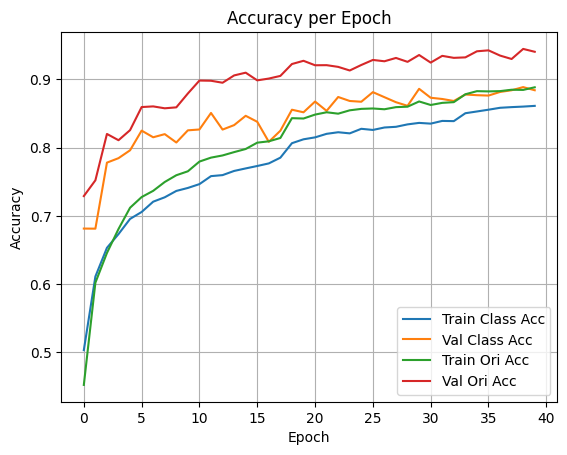

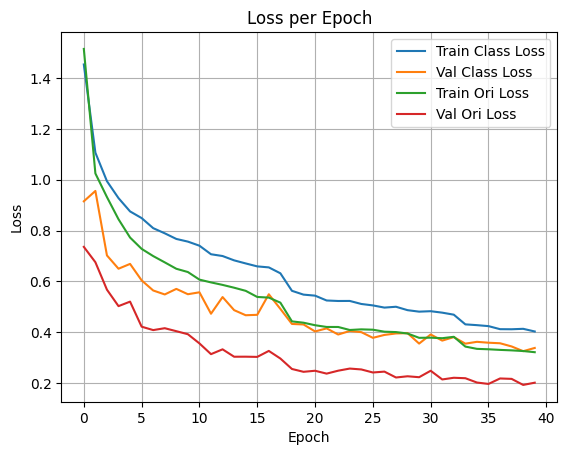

In [6]:

# Plot training & validation accuracy
plt.figure()
plt.plot(history.history['class_accuracy'], label='Train Class Acc')
plt.plot(history.history['val_class_accuracy'], label='Val Class Acc')
plt.plot(history.history['orientation_accuracy'], label='Train Ori Acc')
plt.plot(history.history['val_orientation_accuracy'], label='Val Ori Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(history.history['class_loss'], label='Train Class Loss')
plt.plot(history.history['val_class_loss'], label='Val Class Loss')
plt.plot(history.history['orientation_loss'], label='Train Ori Loss')
plt.plot(history.history['val_orientation_loss'], label='Val Ori Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predict class and orientation labels
pred_class_probs, pred_ori_probs = model.predict(X_test)

# Convert probabilities to class indices
pred_class_labels = np.argmax(pred_class_probs, axis=1)
pred_ori_labels = np.argmax(pred_ori_probs, axis=1)

225/225 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step


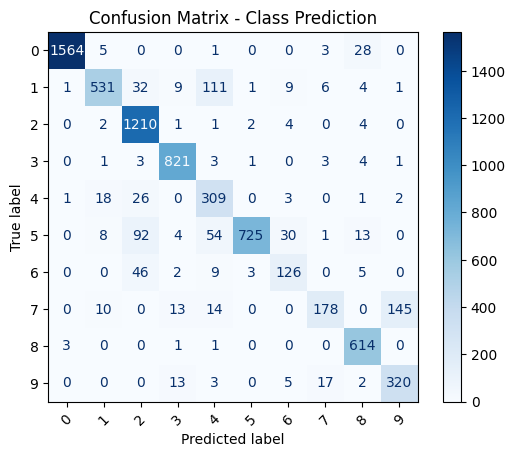

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_class = confusion_matrix(y_class_test, pred_class_labels)

disp_class = ConfusionMatrixDisplay(confusion_matrix=cm_class)
disp_class.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Class Prediction")
plt.show()

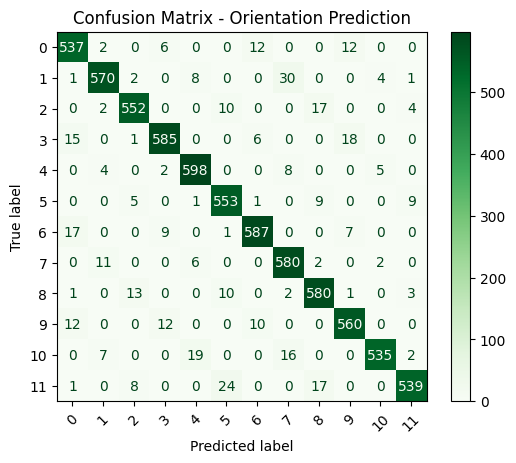

In [9]:
# Compute confusion matrix
cm_ori = confusion_matrix(y_ori_test, pred_ori_labels)


disp_ori = ConfusionMatrixDisplay(confusion_matrix=cm_ori)
disp_ori.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Orientation Prediction")
plt.show()